***Домашнее задание #4. Применение бертоподобных моделей к задаче классификации***

Решите задачу классификации по тональности на подготовленном в тетрадке корпусе, используя пайплайн с Trainer  от HuggingFace. 



примените к данным готовую модель для классификации последовательности (типа BertForSequenceClassification) -- 2 балла


In [1]:
!pip install -q -U watermark

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 2.1.3 which is incompatible.


In [2]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 4.2 MB/s 
     |████████████████████████████████| 67 kB 5.5 MB/s 
     |████████████████████████████████| 895 kB 34.6 MB/s 
     |████████████████████████████████| 6.5 MB 27.4 MB/s 
     |████████████████████████████████| 596 kB 48.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 5.5.0

numpy       : 1.21.5
pandas      : 1.3.5
torch       : 1.10.0+cu111
transformers: 4.17.0



In [4]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 48.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
100% 7.17M/7.17M [00:00<00:00, 62.2MB/s]


In [5]:
import transformers
from transformers import BertModel, AutoTokenizer, BertTokenizer, PreTrainedTokenizerFast, AdamW, get_linear_schedule_with_warmup
import torch.nn.functional as F

import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader

In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 8, 6

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import torch
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import EarlyStoppingCallback

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
df = pd.read_csv("reviews.csv")

Сначала уменьшаем количество классов.

In [10]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

In [11]:
class_names = ['negative', 'neutral', 'positive']

Загружаем предобученную модель и определяем токенизатор.

In [12]:
model_name = "bert-base-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Разбиваем выборку на подвыборки: трейновую, валидационную и тестовую.

In [13]:
X = list(df["content"])
y = list(df["sentiment"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=160)
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=160)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=160)

Класс для датасета, в который сразу загружаются токенизированные тексты, в изначальной тетрадке токенизация происходила в самом классе.

In [14]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [15]:
train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

Функция для подсчета метрик.

In [16]:
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred,average='weighted' )
    precision = precision_score(y_true=labels, y_pred=pred,average='weighted')
    f1 = f1_score(y_true=labels, y_pred=pred,average='weighted')

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

Определяем аргументы: отчет по метрикам происходит на каждом 500-том шаге, размер батча=16:

In [17]:
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    seed=0,
    logging_steps=300,
    load_best_model_at_end=True,
)

In [18]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

In [19]:
trainer.train()

***** Running training *****
  Num examples = 14171
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1772


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
500,0.790800,0.644991,0.702668,0.733189,0.702668,0.707476
1000,0.630200,0.577817,0.763659,0.761470,0.763659,0.762428
1500,0.378000,0.479836,0.834816,0.835097,0.834816,0.834547


***** Running Evaluation *****
  Num examples = 787
  Batch size = 16
Saving model checkpoint to output/checkpoint-500
Configuration saved in output/checkpoint-500/config.json
Model weights saved in output/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 787
  Batch size = 16
Saving model checkpoint to output/checkpoint-1000
Configuration saved in output/checkpoint-1000/config.json
Model weights saved in output/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 787
  Batch size = 16
Saving model checkpoint to output/checkpoint-1500
Configuration saved in output/checkpoint-1500/config.json
Model weights saved in output/checkpoint-1500/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from output/checkpoint-1500 (score: 0.4798356890678406).


TrainOutput(global_step=1772, training_loss=0.553645984313827, metrics={'train_runtime': 1711.699, 'train_samples_per_second': 16.558, 'train_steps_per_second': 1.035, 'total_flos': 2330362651639680.0, 'train_loss': 0.553645984313827, 'epoch': 2.0})

Прогоним также на тестовой выборке:

In [20]:
test_dataset = Dataset(X_test_tokenized)

In [21]:
model_path = "output/checkpoint-1500"
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=3)

# Define test trainer
test_trainer = Trainer(model)

# Make prediction
raw_pred, _, _ = test_trainer.predict(test_dataset)

# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)

loading configuration file output/checkpoint-1500/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file output/checkp

In [22]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
recall = recall_score(y_true=y_test, y_pred=y_pred,average='weighted' )
precision = precision_score(y_true=y_test, y_pred=y_pred,average='weighted')
f1 = f1_score(y_true=y_test, y_pred=y_pred,average='weighted')
print('ACCURACY: ' + str(accuracy))
print('RECALL: ' + str(recall))
print('PRECISION: ' + str(precision))
print('F1: ' + str(f1))

ACCURACY: 0.8210659898477157
RECALL: 0.8210659898477157
PRECISION: 0.8225238602345203
F1: 0.8210935939780045


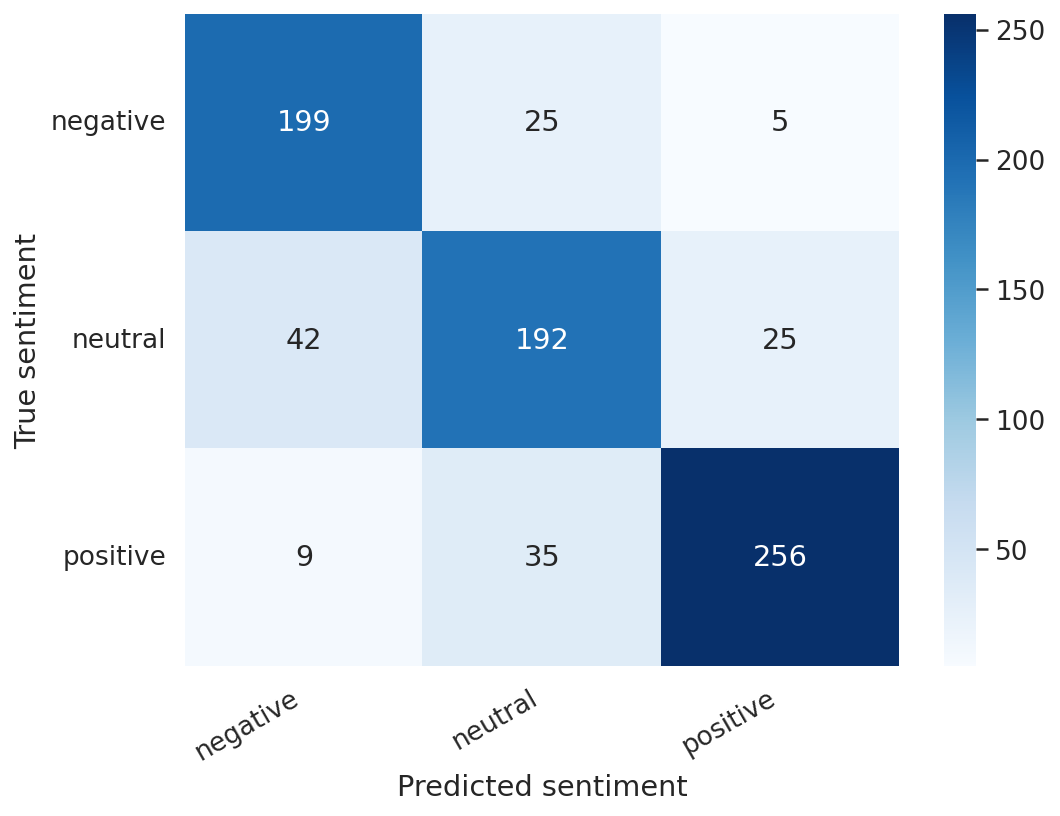

In [23]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

Также возьмем четыре отзыва из гугл-плей:

The whole game is ruined with the PR system. You upgrade parts and the PR doesn't increase? You win mystery parts but never get what you need and it just wastes the days on special events so they never get completed! I know you want to make money but you've ruined what could potentially be a very go

Оценка на гугл-плей: 2

Good game. Please add multiplayer mode so we can play with friends. It will be much fun if we can play with our friendlist than random live player.

Оценка на гугл-плей: 5

Convoluted rewards and parts system. The game is far too difficult to setup and understand before you can get to a race. A never-ending confusion of terms such as money, gold, parts, black market, etc. Gone are the days when NFS was just about selecting a car and selecting a track to race on. On the PC it was an amazing experience until NFS MW. Now it's just all monetized garbage and again, hate to say it again, VERY complicated to understand how to start a race.

Оценка на гугл-плей: 1

The reason I'm giving three stars to this game. It's because of its VIP in game system. You purchased bundle pack on the game and it throws out Ads. Every time you a win race in the game. Majority of the games I play don't shows Ads after you purchased a pack or bundle. The fuel system in this game so I can play more into this game is somewhat lacking. It should of gave you additional tickets for the other races like those you have a certain time to complete.

Оценка на гугл-плей: 3

In [24]:
first_review = "The whole game is ruined with the PR system. You upgrade parts and the PR doesn't increase? You win mystery parts but never get what you need and it just wastes the days on special events so they never get completed! I know you want to make money but you've ruined what could potentially be a very go"

In [25]:
second_review = "Good game. Please add multiplayer mode so we can play with friends. It will be much fun if we can play with our friendlist than random live player."

In [26]:
third_review = "Convoluted rewards and parts system. The game is far too difficult to setup and understand before you can get to a race. A never-ending confusion of terms such as money, gold, parts, black market, etc. Gone are the days when NFS was just about selecting a car and selecting a track to race on. On the PC it was an amazing experience until NFS MW. Now it's just all monetized garbage and again, hate to say it again, VERY complicated to understand how to start a race."

In [27]:
fourth_review = "The reason I'm giving three stars to this game. It's because of its VIP in game system. You purchased bundle pack on the game and it throws out Ads. Every time you a win race in the game. Majority of the games I play don't shows Ads after you purchased a pack or bundle. The fuel system in this game so I can play more into this game is somewhat lacking. It should of gave you additional tickets for the other races like those you have a certain time to complete."

In [28]:
all_reviews = [first_review, second_review, third_review, fourth_review]

In [29]:
text_tokenized = tokenizer(all_reviews, padding=True, truncation=True, max_length=160)
data = Dataset(text_tokenized)

In [30]:
model_path = "output/checkpoint-1500"

# Define test trainer
test_trainer = Trainer(model)

# Make prediction

raw_pred, _, _ = test_trainer.predict(data)


# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 4
  Batch size = 8


In [31]:
print(f'Review text: {all_reviews[0]}')
print(f'Sentiment  : {class_names[y_pred[0]]}')

Review text: The whole game is ruined with the PR system. You upgrade parts and the PR doesn't increase? You win mystery parts but never get what you need and it just wastes the days on special events so they never get completed! I know you want to make money but you've ruined what could potentially be a very go
Sentiment  : negative


In [32]:
print(f'Review text: {all_reviews[1]}')
print(f'Sentiment  : {class_names[y_pred[1]]}')

Review text: Good game. Please add multiplayer mode so we can play with friends. It will be much fun if we can play with our friendlist than random live player.
Sentiment  : positive


In [33]:
print(f'Review text: {all_reviews[2]}')
print(f'Sentiment  : {class_names[y_pred[2]]}')

Review text: Convoluted rewards and parts system. The game is far too difficult to setup and understand before you can get to a race. A never-ending confusion of terms such as money, gold, parts, black market, etc. Gone are the days when NFS was just about selecting a car and selecting a track to race on. On the PC it was an amazing experience until NFS MW. Now it's just all monetized garbage and again, hate to say it again, VERY complicated to understand how to start a race.
Sentiment  : negative


In [34]:
print(f'Review text: {all_reviews[3]}')
print(f'Sentiment  : {class_names[y_pred[3]]}')

Review text: The reason I'm giving three stars to this game. It's because of its VIP in game system. You purchased bundle pack on the game and it throws out Ads. Every time you a win race in the game. Majority of the games I play don't shows Ads after you purchased a pack or bundle. The fuel system in this game so I can play more into this game is somewhat lacking. It should of gave you additional tickets for the other races like those you have a certain time to complete.
Sentiment  : neutral


Общие выводы: 
Первая модель (SentimentClassfier) - лосс на валидации = 0.4684 \
Вторая модель (CustomSentimentClassifier) - лосс на валидации = 0.43 \
Третья модель (BertForSequenceClassification) - лосс на валидации = 0.378 \
По лоссу третья модель превсоходит остальные.


Метрики на тестовой выборке:
Первая модель - \
ACCURACY: 0.9175126903553299 \
RECALL: 0.9175126903553299 \
PRECISION: 0.9183037130783537 \
F1: 0.9177737389200354

Вторая модель - \
ACCURACY: 0.8210659898477157 \
RECALL: 0.8210659898477157 \
PRECISION: 0.827015758724401 \
F1: 0.8228184114986572

Третья модель - \
ACCURACY: 0.8210659898477157 \
RECALL: 0.8210659898477157 \
PRECISION: 0.8225238602345203 \
F1: 0.8210935939780045

По метрикам лидирует первая модель. На тестовой выборке она правда лучше, чем остальные, определяет все классы (особенно нейтральный, погрешность совсем небольшая). Тем не менее, отзывы с гугл-плея все модели классифицировали правильно.